## Sample from a feature distribution (mimicking GC content, say)

Text(0, 0.5, 'number of examples')

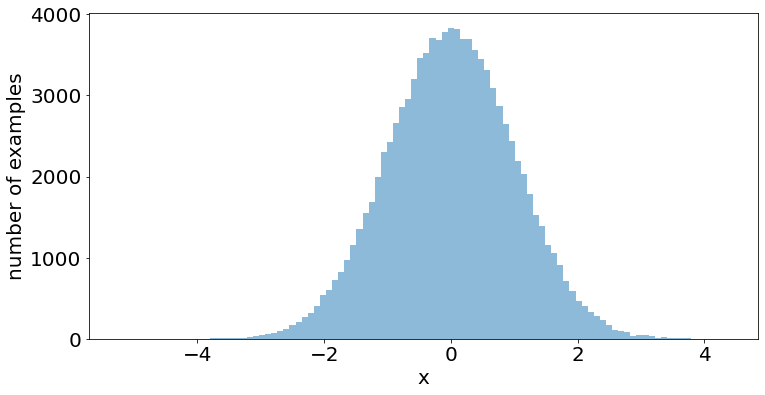

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})

NUMBER_EXAMPLES = 100000 # Number of intervals

# Sample from a univariate normal distribution
MEAN = 0
STD = 1
xs = np.random.normal(loc=MEAN, scale=STD, size=NUMBER_EXAMPLES)

plt.figure(figsize=(12, 6))
plt.hist(xs, bins=100, alpha=0.5)
plt.xlabel('x')
plt.ylabel('number of examples')

## True mapping from feature to target (mimicking SNV counts)

Text(0, 0.5, 'number of examples')

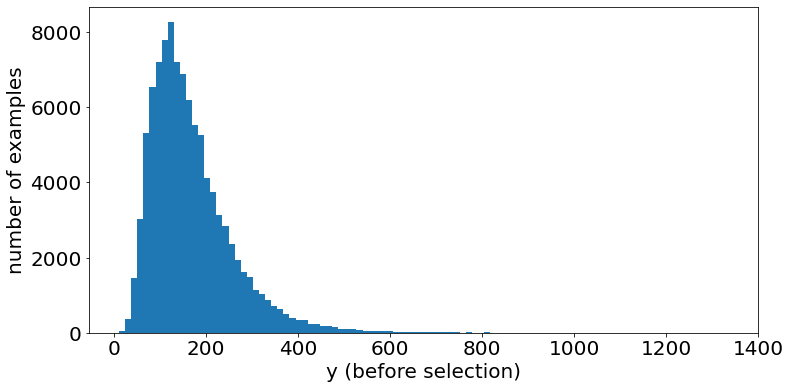

In [2]:
# parameters of true model 
A = 5 
B = 0.5 

TRUE_RATE = lambda x: np.exp(A + B*x) # rate function

ys = np.random.poisson(lam=TRUE_RATE(xs)) # target 

plt.figure(figsize=(12, 6))
plt.hist(ys, bins=100)
plt.xlabel('y (before selection)')
plt.ylabel('number of examples')

## Introduce selection into a small fraction of examples

In [3]:
# Take x% of the examples, declare them to be positive examples, and reduce their y values (possibly in proportion to x), 
# to mimic the effect of negative selection (and how it is stronger in regions with higher GC content, e.g., genes)

# Take the remaining examples, declare them to be neutral (negative) examples, and do not change their y values

POSITIVE_FRACTION = 0.2

num_pos = int(POSITIVE_FRACTION*NUMBER_EXAMPLES)

FRACTIONAL_REDUCTION_IN_Y = 0.2
x_factor = (xs - xs.min()) / (xs.max() - xs.min())
y_pos = ys[:num_pos] * (1 - FRACTIONAL_REDUCTION_IN_Y * x_factor[:num_pos])

# Y_DEPLETION = 20
# y_pos = np.maximum(0, ys[:num_pos] - Y_DEPLETION)

y_neg = ys[num_pos:]
ys = np.concatenate([y_pos, y_neg])

constrained = num_pos*[True] + (NUMBER_EXAMPLES-num_pos)*[False]

DATA = pd.DataFrame({'x': xs, 'y': ys, 'constrained': constrained})
DATA

,x,y,constrained
0,0.755654,189.048455,True
1,0.088142,116.475098,True
2,-0.147190,122.481128,True
3,-1.428652,58.004398,True
4,0.595566,151.990461,True
...,...,...,...
99995,-1.308523,89.000000,False
99996,-1.706549,62.000000,False
99997,0.456604,173.000000,False
99998,-2.014879,55.000000,False


<AxesSubplot:xlabel='x', ylabel='y'>

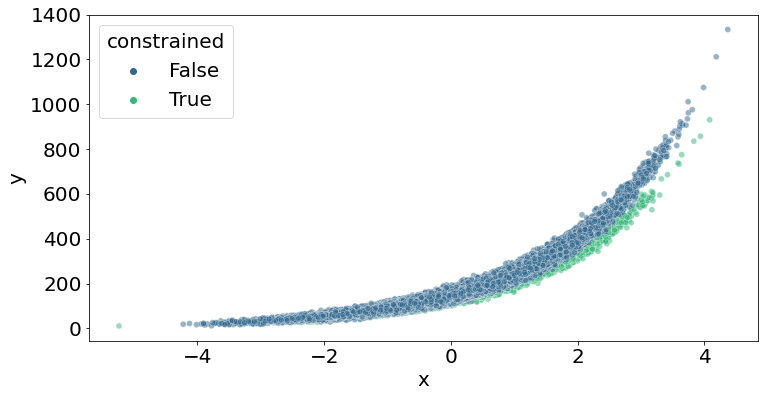

In [4]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x', y='y', hue='constrained', palette='viridis', alpha=0.5)

## Recover the model that generated the neutral data

In [5]:
import statsmodels.api as sm

def fit_poisson_model(feature='x'):
    data_neg = DATA[DATA['constrained'] == 0]
    x_model_neg = sm.add_constant(data_neg[feature])
    model = sm.Poisson(data_neg['y'], x_model_neg).fit()
    x_model = sm.add_constant(DATA[feature])
    DATA[f'predicted_y_model'] = model.predict(x_model)
    DATA[f'standardized_residuals_model'] = (
        DATA[f'predicted_y_model'] - DATA['y'] 
    ) / np.sqrt(DATA[f'predicted_y_model'])
    return model.params

# Fit Poisson Model 1: y ~ x
coefficients_model = fit_poisson_model()
print("Coefficients for Model:", coefficients_model)

DATA

Optimization terminated successfully.
         Current function value: 3.919052
         Iterations 5
Coefficients for Model: const    4.999460
x        0.500334
dtype: float64


,x,y,constrained,predicted_y_model,standardized_residuals_model
0,0.755654,189.048455,True,216.488910,1.864977
1,0.088142,116.475098,True,155.021032,3.095874
2,-0.147190,122.481128,True,137.801791,1.305119
3,-1.428652,58.004398,True,72.577681,1.710629
4,0.595566,151.990461,True,199.825063,3.383897
...,...,...,...,...,...
99995,-1.308523,89.000000,False,77.073677,-1.358481
99996,-1.706549,62.000000,False,63.156525,0.145528
99997,0.456604,173.000000,False,186.403659,0.981739
99998,-2.014879,55.000000,False,54.127812,-0.118550


In [6]:
def plot_y(constrained):
    df = DATA[DATA['constrained'] == constrained]

    x_ = np.linspace(df['x'].min(), df['x'].max(), 100)
    y_ = TRUE_RATE(x_)

    plt.figure(figsize=(12, 6))
    plt.plot(df['x'], df['y'], 'o', alpha=0.5, label='y')
    plt.plot(df['x'], df['predicted_y_model'], 'o', label='Learned rate')
    plt.plot(x_, y_, label='True rate', color='black')
    plt.yscale('log')
    plt.xlabel('x')
    plt.title(f'Constrained = {constrained}')
    plt.legend()
    plt.xlim(-5, 5)
    plt.ylim(1, 1e3)

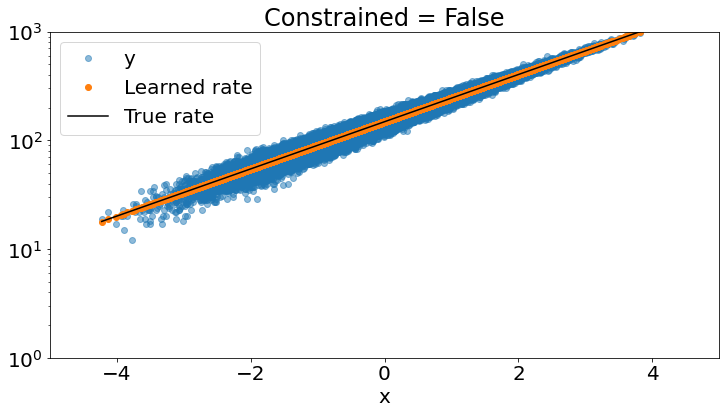

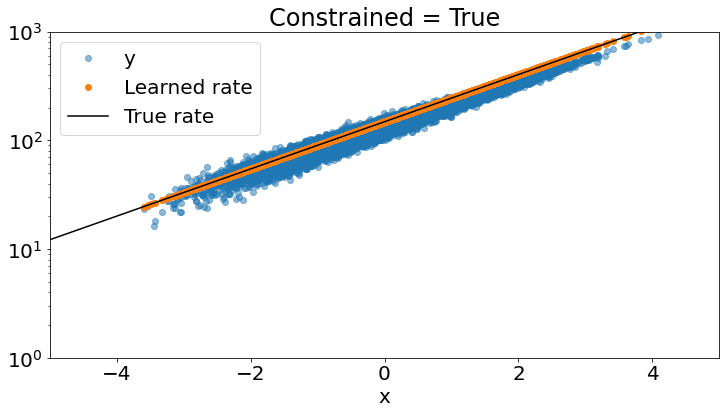

In [7]:
plot_y(constrained=False)
plot_y(constrained=True)

## Residual patterns for negative and positive examples

In [10]:
def plot_residuals(constrained):
    df = DATA[DATA['constrained'] == constrained].copy()

    df[f'x_bin_midpoints'] = (pd
        .cut(df['x'], bins=20, labels=None)
        .apply(lambda x: (x.right + x.left) / 2)
    )
    average_residual = df.groupby(f'x_bin_midpoints')[f'standardized_residuals_model'].mean()  

    plt.figure(figsize=(10, 6))
    plt.scatter(df['x'], df[f'standardized_residuals_model'], alpha=0.7, label='standardized residuals')
    plt.plot(average_residual.index, average_residual.values, color='red', lw=2, label=f'mean residual') 
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('x')
    plt.ylim(-10, 10)

    # if constrained:
    #     x_ = np.linspace(df['x'].min(), df['x'].max(), 100)
    #     mu = TRUE_RATE(x_)
    #     sigma = np.sqrt(mu)
    #     y_ = Y_DEPLETION / sigma # this depends on how selection affects y values
    #     plt.plot(x_, y_, color='black', lw=2, label='expected mean')

    plt.legend()

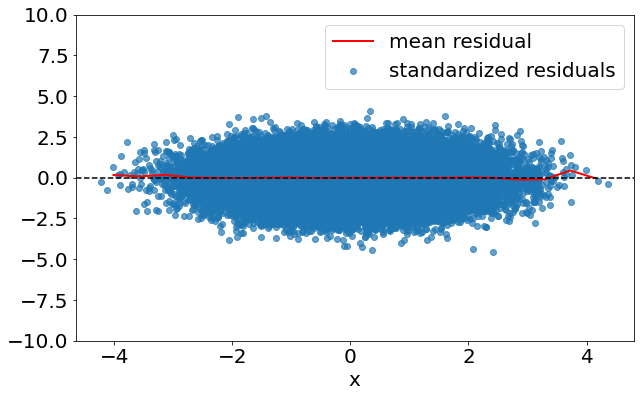

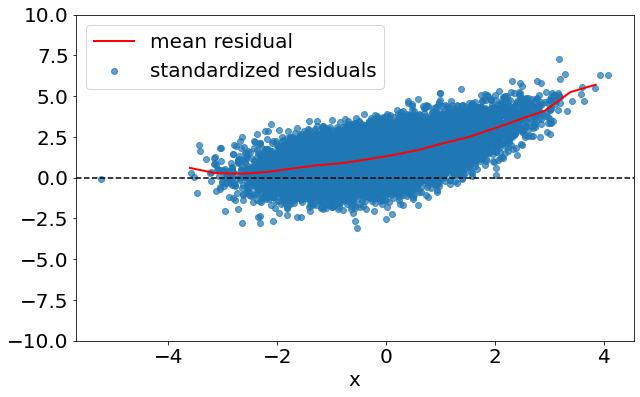

In [11]:
plot_residuals(constrained=False)
plot_residuals(constrained=True)

## Bias in the residuals of the positive examples causes performance to vary with feature stratum, even though the model is complete

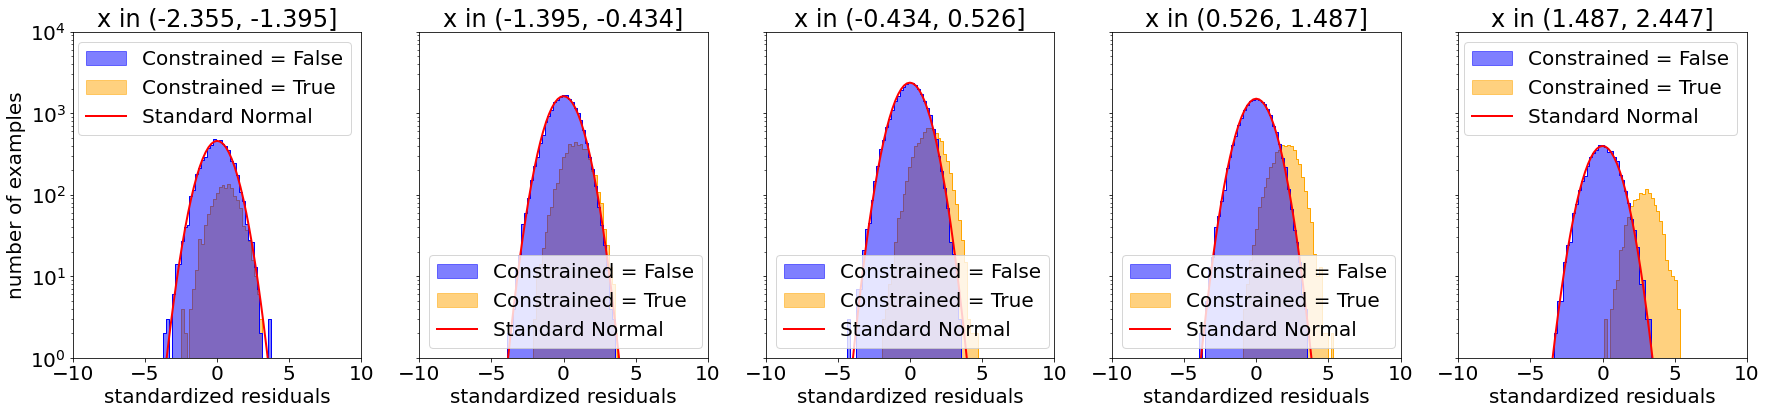

In [12]:
import seaborn as sns
from matplotlib.patches import Patch

NUMBER_EXAMPLES_MIN = 1000

def plot_residual_distributions():
    df = DATA.copy()

    df['x_bin'] = (pd
        .cut(df['x'], bins=10, labels=None)
    )
    groups = df.groupby('x_bin')
    filtered_groups = {x_bin: group for x_bin, group in groups if len(group) > NUMBER_EXAMPLES_MIN}

    fig, axes = plt.subplots(1, len(filtered_groups), figsize=(6 * len(filtered_groups), 6), sharey=True)
    
    for i, (x_bin, group) in enumerate(filtered_groups.items()):        
        ax = axes[i] 

        bins = np.linspace(-10, 10, 100)
        bin_centers = (bins[1:] + bins[:-1]) / 2
        bin_width = bins[1] - bins[0]

        palette = {False: 'blue', True: 'orange'}
        alpha = 0.5  

        sns.histplot(
            data=group, 
            x=f'standardized_residuals_model', 
            hue='constrained', 
            kde=False, 
            element='step', 
            bins=bins, 
            ax=ax, 
            palette=palette, 
            alpha=alpha
        )

        # plot standard normal 
        x = bin_centers
        y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
        negative_class_count = len(group[group['constrained'] == False])
        y_scaled = y * negative_class_count * bin_width  
        normal_line, = ax.plot(x, y_scaled, color='red', lw=2)

        ax.set_xlabel(f'standardized residuals')
        ax.set_ylabel('number of examples')
        ax.set_title(f'x in {x_bin}')
        ax.set_yscale('log')  
        ax.set_xlim(-10, 10)
        ax.set_ylim(1, 1e4)

        # Manually create legend handles and labels
        handles = [
            Patch(color=palette[False], alpha=alpha),
            Patch(color=palette[True], alpha=alpha),
            normal_line
        ]
        labels = [
            'Constrained = False', 
            'Constrained = True', 
            'Standard Normal'
        ]
        ax.legend(handles=handles, labels=labels)

    plt.show()

plot_residual_distributions()

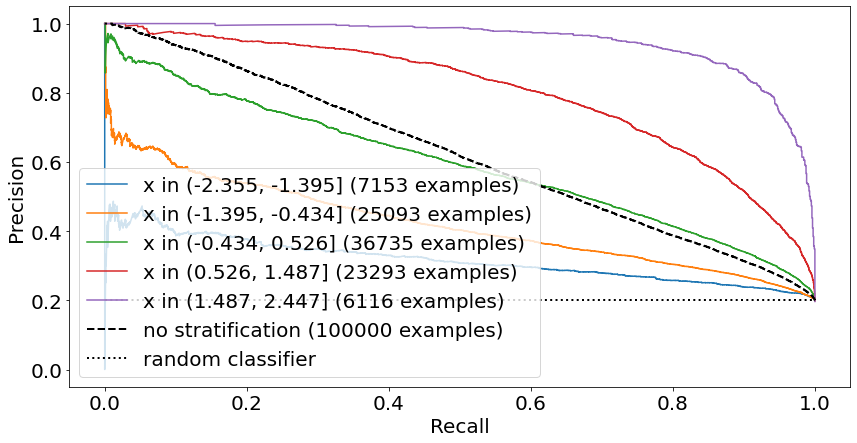

In [13]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curves():
    df = DATA.copy()

    df['x_bin'] = (pd
        .cut(df['x'], bins=10, labels=None)
    )
    groups = df.groupby('x_bin')

    pr_curves = {}
    for x_bin, group in groups:        
        precision, recall, _ = precision_recall_curve(group['constrained'], group[f'standardized_residuals_model'])
        pr_curves[x_bin] = (precision, recall, len(group))

    plt.figure(figsize=(14, 7))
    for x_bin, (precision, recall, num_examples) in pr_curves.items():
        if num_examples > NUMBER_EXAMPLES_MIN:
            plt.plot(recall, precision, label=f'x in {x_bin} ({num_examples} examples)')

    # no stratification    
    precision, recall, _ = precision_recall_curve(df['constrained'], df[f'standardized_residuals_model'])
    plt.plot(recall, precision, label=f'no stratification ({len(df)} examples)', color='black', lw=2, linestyle='--')

    plt.plot([0, 1], [POSITIVE_FRACTION, POSITIVE_FRACTION], color='black', lw=2, linestyle=':', label='random classifier')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

plot_pr_curves()

## TODO: continue from here 

Power for high allele frequency SNPs: 0.1436265709156194
Power for low allele frequency SNPs: 0.2434329256065771
Average effect size for high allele frequency SNPs: 0.19411530420650236
Average effect size for low allele frequency SNPs: -0.032938156209074414
Average standard error for high allele frequency SNPs: 0.31391430083530625
Average standard error for low allele frequency SNPs: 0.30774009426266763
Number of significant tests for high allele frequency SNPs: 720
Number of significant tests for low allele frequency SNPs: 1214


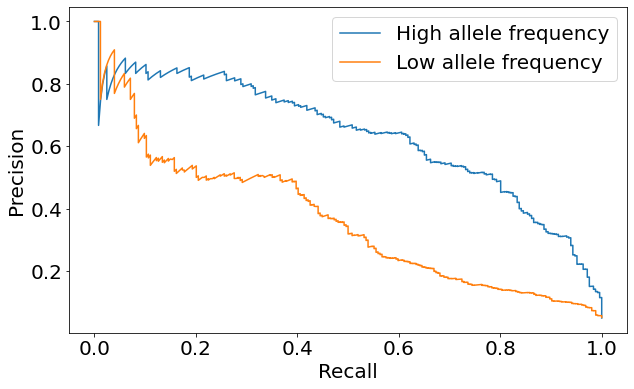

In [49]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.rcParams.update({'font.size': 20}) 

# Seed for reproducibility
np.random.seed(42)

# Simulation parameters
n_samples = 100
n_snps = 10000  # Total number of SNPs
n_disease_snps = 500  # Number of disease-associated SNPs
high_freq = 0.5  # High allele frequency
low_freq = 0.1   # Low allele frequency
true_effect_size = 1  # Effect size of disease-associated SNPs

# Generate SNPs and assign high or low allele frequencies randomly
snp_frequencies = np.random.choice([high_freq, low_freq], size=n_snps)

# Assign which SNPs are disease-associated
disease_snp_indices = np.random.choice(range(n_snps), size=n_disease_snps, replace=False)
neutral_snp_indices = np.setdiff1d(range(n_snps), disease_snp_indices)

# Simulate disease outcome for each SNP based on its frequency and whether it's disease-associated
def simulate_snp_data(freq, n_samples, is_disease_associated):
    snp = np.random.binomial(2, freq, n_samples)
    intercept = -2  # Baseline log-odds for disease
    effect_size = true_effect_size if is_disease_associated else 0
    log_odds = intercept + effect_size * snp
    disease_prob = 1 / (1 + np.exp(-log_odds))
    disease = np.random.binomial(1, disease_prob)
    return snp, disease

# Collect data for all SNPs
snps = []
disease_outcomes = []
snp_labels = []

for i in range(n_snps):
    is_disease_snp = i in disease_snp_indices
    snp, disease = simulate_snp_data(snp_frequencies[i], n_samples, is_disease_snp)
    snps.append(snp)
    disease_outcomes.append(disease)
    snp_labels.append(1 if is_disease_snp else 0)  # Label 1 = disease-associated, 0 = neutral

# Convert to numpy arrays for convenience
snps = np.array(snps).T  # SNP data shape: (n_samples, n_snps)
disease_outcomes = np.array(disease_outcomes).T  # Shape: (n_samples, n_snps)
snp_labels = np.array(snp_labels)

alpha = 0.05  # Significance level
estimated_effect_sizes = []
standard_errors = []
p_values = []
power_high = 0
power_low = 0

high_effect_sizes = []
low_effect_sizes = []
high_standard_errors = []
low_standard_errors = []

for i in range(n_snps):
    model = LogisticRegression()
    model.fit(snps[:, i].reshape(-1, 1), disease_outcomes[:, i])
    effect_size = model.coef_[0][0]
    estimated_effect_sizes.append(effect_size)
    
    # Compute standard error
    p = model.predict_proba(snps[:, i].reshape(-1, 1))[:, 1]
    se = np.sqrt(np.sum(p * (1 - p)) / len(p))
    standard_errors.append(se)
    
    # Compute z-score
    z_score = effect_size / se
    
    # Compute p-value
    p_value = 2 * (1 - norm.cdf(np.abs(z_score)))
    p_values.append(p_value)
    
    # Check if p-value is less than significance level
    if p_value < alpha:
        if snp_frequencies[i] == high_freq:
            power_high += 1
            high_effect_sizes.append(effect_size)
            high_standard_errors.append(se)
        elif snp_frequencies[i] == low_freq:
            power_low += 1
            low_effect_sizes.append(effect_size)
            low_standard_errors.append(se)

# Compute power as the proportion of significant tests
power_high /= len(np.where(snp_frequencies == high_freq)[0])
power_low /= len(np.where(snp_frequencies == low_freq)[0])

print(f"Power for high allele frequency SNPs: {power_high}")
print(f"Power for low allele frequency SNPs: {power_low}")

# Diagnostic outputs
print(f"Average effect size for high allele frequency SNPs: {np.mean(high_effect_sizes)}")
print(f"Average effect size for low allele frequency SNPs: {np.mean(low_effect_sizes)}")
print(f"Average standard error for high allele frequency SNPs: {np.mean(high_standard_errors)}")
print(f"Average standard error for low allele frequency SNPs: {np.mean(low_standard_errors)}")
print(f"Number of significant tests for high allele frequency SNPs: {len(high_effect_sizes)}")
print(f"Number of significant tests for low allele frequency SNPs: {len(low_effect_sizes)}")

# Split SNPs by allele frequency (high vs low)
high_freq_indices = np.where(snp_frequencies == high_freq)[0]
low_freq_indices = np.where(snp_frequencies == low_freq)[0]

# Compute PR AUC for high and low allele frequency SNPs
precision_high, recall_high, _ = precision_recall_curve(snp_labels[high_freq_indices], np.array(estimated_effect_sizes)[high_freq_indices])
precision_low, recall_low, _ = precision_recall_curve(snp_labels[low_freq_indices], np.array(estimated_effect_sizes)[low_freq_indices])

# Plot PR curves
plt.figure(figsize=(10, 6))
plt.plot(recall_high, precision_high, label=f'High allele frequency')
plt.plot(recall_low, precision_low, label=f'Low allele frequency')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

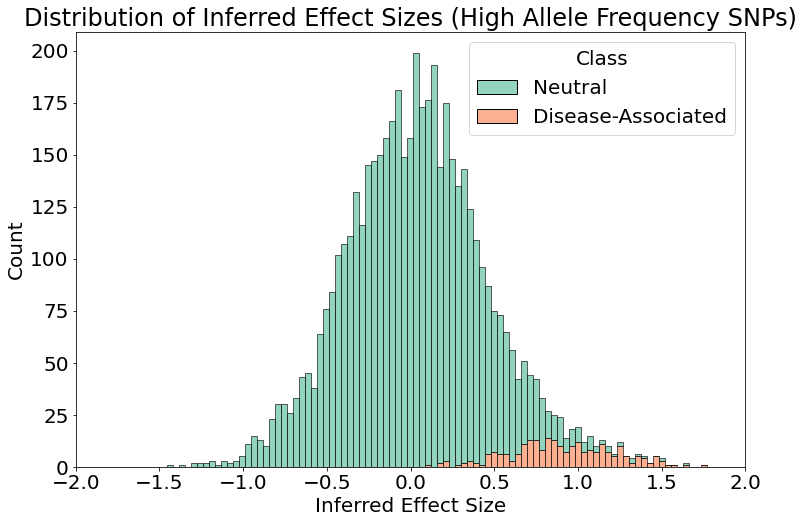

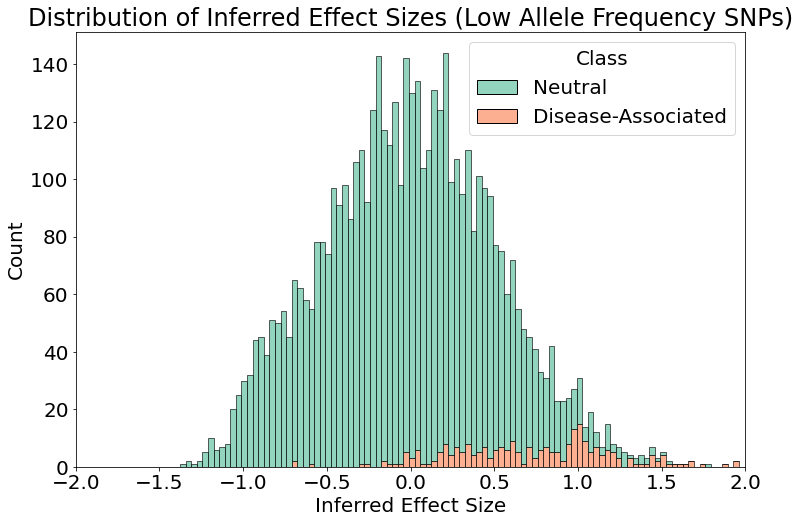

In [51]:
import seaborn as sns

# Separate SNPs by neutral vs disease-associated and by high vs low allele frequency
effect_sizes_neutral_high = np.array(estimated_effect_sizes)[high_freq_indices][snp_labels[high_freq_indices] == 0]
effect_sizes_disease_high = np.array(estimated_effect_sizes)[high_freq_indices][snp_labels[high_freq_indices] == 1]
effect_sizes_neutral_low = np.array(estimated_effect_sizes)[low_freq_indices][snp_labels[low_freq_indices] == 0]
effect_sizes_disease_low = np.array(estimated_effect_sizes)[low_freq_indices][snp_labels[low_freq_indices] == 1]

# Create a dataframe for easier plotting with Seaborn
df_effect_sizes = pd.DataFrame({
    'Effect Size': np.concatenate([effect_sizes_neutral_high, effect_sizes_disease_high,
                                   effect_sizes_neutral_low, effect_sizes_disease_low]),
    'Class': (['Neutral'] * len(effect_sizes_neutral_high) +
              ['Disease-Associated'] * len(effect_sizes_disease_high) +
              ['Neutral'] * len(effect_sizes_neutral_low) +
              ['Disease-Associated'] * len(effect_sizes_disease_low)),
    'Allele Frequency': (['High'] * len(effect_sizes_neutral_high) +
                         ['High'] * len(effect_sizes_disease_high) +
                         ['Low'] * len(effect_sizes_neutral_low) +
                         ['Low'] * len(effect_sizes_disease_low))
})

# Plot histograms using Seaborn
plt.figure(figsize=(12, 8))

# Plot for High allele frequency SNPs
sns.histplot(data=df_effect_sizes[df_effect_sizes['Allele Frequency'] == 'High'],
             x='Effect Size', hue='Class', multiple='stack', bins=100, palette='Set2', alpha=0.7)
plt.title('Distribution of Inferred Effect Sizes (High Allele Frequency SNPs)')
plt.xlabel('Inferred Effect Size')
plt.ylabel('Count')
plt.xlim(-2, 2)
plt.show()

plt.figure(figsize=(12, 8))

# Plot for Low allele frequency SNPs
sns.histplot(data=df_effect_sizes[df_effect_sizes['Allele Frequency'] == 'Low'],
             x='Effect Size', hue='Class', multiple='stack', bins=100, palette='Set2', alpha=0.7)
plt.title('Distribution of Inferred Effect Sizes (Low Allele Frequency SNPs)')
plt.xlabel('Inferred Effect Size')
plt.ylabel('Count')
plt.xlim(-2, 2)
plt.show()
